# Sentiment Analysis to predict stock price direction using Classifier models

## 1. Introduction
A selection of machine learning classifier models will be used to predict whether the next day Adjusted Close price of AstraZeneca stock will increase or decrease based on sentiment analysis of market news articles from 2014-2021 collected by web scraping from [Investing.com](https://uk.investing.com/equities/astrazeneca-news).

Sentiment Analysis is the use of NLP, text analysis and
computational linguistics to determine subjective information. Instead of building our own lexicon to do this, we will use VADER (Valence Aware Dictionary and sEntiment Reasoner), a pre-trained sentiment analysis model included in the NLTK package. We will also use TextBlob, a simple API built upon NLTK, for common NLP tasks.




## 2. Install/import libraries

In [ ]:
!pip install yfinance

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as dates
import seaborn as sns
import seaborn as sns
import math
import datetime
import re
import yfinance as yf
import nltk
import warnings
warnings.filterwarnings('ignore')

from datetime import date, timedelta
from nltk.sentiment.vader import SentimentIntensityAnalyzer
nltk.downloader.download('vader_lexicon')
from textblob import TextBlob

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import SGDClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import scale

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


## 3. Import data





In [ ]:
# Show DataFrame of article sentiments data

article_sentiments = pd.read_pickle('azn_article_sentiments.pkl')
article_sentiments

ticker publish_date  \
0    AZN.L  2021-01-04    
1    AZN.L  2021-01-05    
2    AZN.L  2021-01-04    
3    AZN.L  2020-12-31    
4    AZN.L  2020-12-31    
..     ...         ...    
813  AZN.L  2016-05-17    
814  AZN.L  2016-05-16    
815  AZN.L  2016-05-09    
816  AZN.L  2016-05-17    
817  AZN.L  2016-07-28    

                                                                                                  title  \
0    UK rolls out Oxford-AstraZeneca vaccine as it battles against Covid surge                            
1    The UK is delaying second vaccine shots and it's proving controversial. Here's what we know so far   
2    UK Stocks-Factors to watch on Jan. 4 By Reuters                                                      
3    NTGR: 3 Small-Cap Stocks for Faster Economic Growth in 2021: NETGEAR, ADTRAN, and Apogee             
4    UK Stocks-Factors to watch on Dec 31 By Reuters                                                      
..                                               ...                                                      
813  Novartis splits drugs business into two, pharma chief to leave By Reuters                            
814  Sweden shares higher at close of trade; OMX Stockholm 30 up 0.98% By Investing.com                   
815  Sweden shares higher at close of trade; OMX Stockholm 30 up 1.45% By Investing.com                   
816  Sweden shares lower at close of trade; OMX Stockholm 30 down 0.33% By Investing.com                  
817  AstraZeneca a bid target again? CEO says someone may spot value By Reuters                           

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [ ]:
# Create copy of DataFrame

article_sentiments_azn = article_sentiments.copy()
article_sentiments_azn.head(5)

ticker publish_date  \
0  AZN.L  2021-01-04    
1  AZN.L  2021-01-05    
2  AZN.L  2021-01-04    
3  AZN.L  2020-12-31    
4  AZN.L  2020-12-31    

                                                                                                title  \
0  UK rolls out Oxford-AstraZeneca vaccine as it battles against Covid surge                            
1  The UK is delaying second vaccine shots and it's proving controversial. Here's what we know so far   
2  UK Stocks-Factors to watch on Jan. 4 By Reuters                                                      
3  NTGR: 3 Small-Cap Stocks for Faster Economic Growth in 2021: NETGEAR, ADTRAN, and Apogee             
4  UK Stocks-Factors to watch on Dec 31 By Reuters                                                      

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    

## 4. Clean news data

Prepare data for further processing by appending separator to body text of each article.

In [ ]:
# Append ---newarticle--- to split for NLP

article_sentiments_azn['body_text'] = article_sentiments_azn['body_text'].astype(str) + '---newarticle---'

In [ ]:
azn_bodytext = article_sentiments_azn['body_text']
azn_bodytext

0      LONDON — The U.K. has started rolling out the coronavirus vaccine developed by AstraZeneca and the University of Oxford, marking another step in its battle against the coronavirus pandemic.\n\nThe country's National Health Service (NHS) is the first in the world to deploy the jab after it was approved for use in the U.K. by the Medicines and Healthcare products Regulatory Agency (MHRA) last week. The NHS said 82-year-old Brian Pinker was the first person in the world to receive the jab Monday morning.\n\nThe approval and deployment of the Oxford-AstraZeneca vaccine is seen as a boon in the race against Covid-19 as it is cheaper than alternatives created by Pfizer and BioNTech and Moderna.\n\nAdditionally, and unlike rival vaccines, it can be stored, transported and handled at normal refrigerated conditions (2 to 8 degrees Celsius or 36 to 46 degrees Fahrenheit) for at least six months.\n\nWhen the vaccine was approved last week, AstraZeneca said it aimed "to supply millions of d

In [ ]:
pd.set_option("display.max_colwidth", -1)  # to display full text
azn_bodytext

0      LONDON — The U.K. has started rolling out the coronavirus vaccine developed by AstraZeneca and the University of Oxford, marking another step in its battle against the coronavirus pandemic.\n\nThe country's National Health Service (NHS) is the first in the world to deploy the jab after it was approved for use in the U.K. by the Medicines and Healthcare products Regulatory Agency (MHRA) last week. The NHS said 82-year-old Brian Pinker was the first person in the world to receive the jab Monday morning.\n\nThe approval and deployment of the Oxford-AstraZeneca vaccine is seen as a boon in the race against Covid-19 as it is cheaper than alternatives created by Pfizer and BioNTech and Moderna.\n\nAdditionally, and unlike rival vaccines, it can be stored, transported and handled at normal refrigerated conditions (2 to 8 degrees Celsius or 36 to 46 degrees Fahrenheit) for at least six months.\n\nWhen the vaccine was approved last week, AstraZeneca said it aimed "to supply millions of d

In [ ]:
# Save article_sentiments_azn to txt

with open('azn_bodytext.txt', 'w') as f:
    f.write(
        azn_bodytext.to_string(header = False, index = False)
    )

### Remove spaces in text file

In [ ]:
# first get all lines from file
with open('azn_bodytext.txt', 'r') as f:
    lines = f.readlines()

# remove spaces
lines = [line.replace(' ', '') for line in lines]

# finally, write lines in the file
with open('azn_bodytext_20210105.txt', 'w') as f:
    f.writelines(lines)

### Remove end line breaks from text file

In [ ]:
# first get all lines from file
a_file = open("azn_bodytext.txt", "r")

# create variable for string without line breaks
string_without_line_breaks = ""

# iterate over strings
for line in a_file:
  stripped_line = line.rstrip() # rstrip() method removes any trailing characters - space is the default trailing character to remove
  string_without_line_breaks += stripped_line
a_file.close()

In [ ]:
# finally, write lines in the file
with open('azn_bodytext.txt', 'w') as f:
    f.writelines(string_without_line_breaks)

In [ ]:
# Read article sentiments data into DataFrame

azn_news_df = pd.read_pickle('azn_article_sentiments.pkl')
azn_news_df

ticker publish_date  \
0    AZN.L  2021-01-04    
1    AZN.L  2021-01-05    
2    AZN.L  2021-01-04    
3    AZN.L  2020-12-31    
4    AZN.L  2020-12-31    
..     ...         ...    
813  AZN.L  2016-05-17    
814  AZN.L  2016-05-16    
815  AZN.L  2016-05-09    
816  AZN.L  2016-05-17    
817  AZN.L  2016-07-28    

                                                                                                  title  \
0    UK rolls out Oxford-AstraZeneca vaccine as it battles against Covid surge                            
1    The UK is delaying second vaccine shots and it's proving controversial. Here's what we know so far   
2    UK Stocks-Factors to watch on Jan. 4 By Reuters                                                      
3    NTGR: 3 Small-Cap Stocks for Faster Economic Growth in 2021: NETGEAR, ADTRAN, and Apogee             
4    UK Stocks-Factors to watch on Dec 31 By Reuters                                                      
..                                               ...                                                      
813  Novartis splits drugs business into two, pharma chief to leave By Reuters                            
814  Sweden shares higher at close of trade; OMX Stockholm 30 up 0.98% By Investing.com                   
815  Sweden shares higher at close of trade; OMX Stockholm 30 up 1.45% By Investing.com                   
816  Sweden shares lower at close of trade; OMX Stockholm 30 down 0.33% By Investing.com                  
817  AstraZeneca a bid target again? CEO says someone may spot value By Reuters                           

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [ ]:
# Check data types

azn_news_df.dtypes

ticker          object 
publish_date    object 
title           object 
body_text       object 
url             object 
neg             float64
neu             float64
pos             float64
compound        float64
dtype: object

In [ ]:
# Create copy of DataFrame

azn_news_df_new = azn_news_df.copy()

### Drop rows without publish date

In [ ]:
# Drop rows with None in publish_date column

azn_news_df_new = azn_news_df_new.replace(to_replace='None', value=np.nan).dropna()
azn_news_df_new

ticker publish_date  \
0    AZN.L  2021-01-04    
1    AZN.L  2021-01-05    
2    AZN.L  2021-01-04    
3    AZN.L  2020-12-31    
4    AZN.L  2020-12-31    
..     ...         ...    
813  AZN.L  2016-05-17    
814  AZN.L  2016-05-16    
815  AZN.L  2016-05-09    
816  AZN.L  2016-05-17    
817  AZN.L  2016-07-28    

                                                                                                  title  \
0    UK rolls out Oxford-AstraZeneca vaccine as it battles against Covid surge                            
1    The UK is delaying second vaccine shots and it's proving controversial. Here's what we know so far   
2    UK Stocks-Factors to watch on Jan. 4 By Reuters                                                      
3    NTGR: 3 Small-Cap Stocks for Faster Economic Growth in 2021: NETGEAR, ADTRAN, and Apogee             
4    UK Stocks-Factors to watch on Dec 31 By Reuters                                                      
..                                               ...                                                      
813  Novartis splits drugs business into two, pharma chief to leave By Reuters                            
814  Sweden shares higher at close of trade; OMX Stockholm 30 up 0.98% By Investing.com                   
815  Sweden shares higher at close of trade; OMX Stockholm 30 up 1.45% By Investing.com                   
816  Sweden shares lower at close of trade; OMX Stockholm 30 down 0.33% By Investing.com                  
817  AstraZeneca a bid target again? CEO says someone may spot value By Reuters                           

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

### Drop rows with duplicate titles

In [ ]:
# Dropping all duplicate titles keeping only the first instance

azn_news_df_new.drop_duplicates(subset ="title",
                     keep = 'first', inplace = True)

azn_news_df_new

ticker publish_date  \
0    AZN.L  2021-01-04    
1    AZN.L  2021-01-05    
2    AZN.L  2021-01-04    
3    AZN.L  2020-12-31    
4    AZN.L  2020-12-31    
..     ...         ...    
811  AZN.L  2016-05-12    
812  AZN.L  2016-05-18    
813  AZN.L  2016-05-17    
815  AZN.L  2016-05-09    
817  AZN.L  2016-07-28    

                                                                                                  title  \
0    UK rolls out Oxford-AstraZeneca vaccine as it battles against Covid surge                            
1    The UK is delaying second vaccine shots and it's proving controversial. Here's what we know so far   
2    UK Stocks-Factors to watch on Jan. 4 By Reuters                                                      
3    NTGR: 3 Small-Cap Stocks for Faster Economic Growth in 2021: NETGEAR, ADTRAN, and Apogee             
4    UK Stocks-Factors to watch on Dec 31 By Reuters                                                      
..                                               ...                                                      
811  AstraZeneca drug wins orphan status in thyroid cancer By Reuters                                     
812  Pascal Soriot's big experiment: reinventing AstraZeneca By Reuters                                   
813  Novartis splits drugs business into two, pharma chief to leave By Reuters                            
815  Sweden shares higher at close of trade; OMX Stockholm 30 up 1.45% By Investing.com                   
817  AstraZeneca a bid target again? CEO says someone may spot value By Reuters                           

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

### Set datetime index

In [ ]:
# Set string representation of date to datetime index

azn_news_df_new['Date'] = pd.to_datetime(azn_news_df_new.publish_date)
azn_news_df_new.set_index('Date', inplace=True)
azn_news_df_new

ticker publish_date  \
Date                             
2021-01-04  AZN.L  2021-01-04    
2021-01-05  AZN.L  2021-01-05    
2021-01-04  AZN.L  2021-01-04    
2020-12-31  AZN.L  2020-12-31    
2020-12-31  AZN.L  2020-12-31    
...           ...         ...    
2016-05-12  AZN.L  2016-05-12    
2016-05-18  AZN.L  2016-05-18    
2016-05-17  AZN.L  2016-05-17    
2016-05-09  AZN.L  2016-05-09    
2016-07-28  AZN.L  2016-07-28    

                                                                                                         title  \
Date                                                                                                             
2021-01-04  UK rolls out Oxford-AstraZeneca vaccine as it battles against Covid surge                            
2021-01-05  The UK is delaying second vaccine shots and it's proving controversial. Here's what we know so far   
2021-01-04  UK Stocks-Factors to watch on Jan. 4 By Reuters                                                      
2020-12-31  NTGR: 3 Small-Cap Stocks for Faster Economic Growth in 2021: NETGEAR, ADTRAN, and Apogee             
2020-12-31  UK Stocks-Factors to watch on Dec 31 By Reuters                                                      
...                                                                                              ...             
2016-05-12  AstraZeneca drug wins orphan status in thyroid cancer By Reuters                                     
2016-05-18  Pascal Soriot's big experiment: reinventing AstraZeneca By Reuters                                   
2016-05-17  Novartis splits drugs business into two, pharma chief to leave By Reuters                            
2016-05-09  Sweden shares higher at close of trade; OMX Stockholm 30 up 1.45% By Investing.com                   
2016-07-28  AstraZeneca a bid target again? CEO says someone may spot value By Reuters                           

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [ ]:
# Show dateime index of new DataFrame

azn_news_df_new.index

DatetimeIndex(['2021-01-04', '2021-01-05', '2021-01-04', '2020-12-31',
               '2020-12-31', '2020-12-30', '2020-12-30', '2020-12-30',
               '2020-12-30', '2020-12-30',
               ...
               '2016-06-07', '2016-06-16', '2016-05-17', '2016-05-18',
               '2016-05-17', '2016-05-12', '2016-05-18', '2016-05-17',
               '2016-05-09', '2016-07-28'],
              dtype='datetime64[ns]', name='Date', length=709, freq=None)

### Sort in ascending chronological order

In [ ]:
# Sort in chronological order

azn_news_df_new = azn_news_df_new.sort_index()
azn_news_df_new

ticker publish_date  \
Date                             
2016-05-09  AZN.L  2016-05-09    
2016-05-12  AZN.L  2016-05-12    
2016-05-17  AZN.L  2016-05-17    
2016-05-17  AZN.L  2016-05-17    
2016-05-17  AZN.L  2016-05-17    
...           ...         ...    
2020-12-31  AZN.L  2020-12-31    
2020-12-31  AZN.L  2020-12-31    
2021-01-04  AZN.L  2021-01-04    
2021-01-04  AZN.L  2021-01-04    
2021-01-05  AZN.L  2021-01-05    

                                                                                                         title  \
Date                                                                                                             
2016-05-09  Sweden shares higher at close of trade; OMX Stockholm 30 up 1.45% By Investing.com                   
2016-05-12  AstraZeneca drug wins orphan status in thyroid cancer By Reuters                                     
2016-05-17  Novartis splits drugs business into two, pharma chief to leave By Reuters                            
2016-05-17  AstraZeneca asthma drug hits goal, to enter competitive market By Reuters                            
2016-05-17  Pfizer's Anacor deal showcases new wave of eczema therapies By Reuters                               
...                                                                               ...                            
2020-12-31  UK Stocks-Factors to watch on Dec 31 By Reuters                                                      
2020-12-31  NTGR: 3 Small-Cap Stocks for Faster Economic Growth in 2021: NETGEAR, ADTRAN, and Apogee             
2021-01-04  UK Stocks-Factors to watch on Jan. 4 By Reuters                                                      
2021-01-04  UK rolls out Oxford-AstraZeneca vaccine as it battles against Covid surge                            
2021-01-05  The UK is delaying second vaccine shots and it's proving controversial. Here's what we know so far   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [ ]:
# Save sorted DataFrame

azn_news_df_new.to_pickle("azn_news_df_new.pkl")

In [ ]:
azn_news_df_new.to_csv("azn_news_df_new.csv", sep=',', encoding='utf-8', header=True)

In [ ]:
azn_news_df_new.dtypes

ticker          object 
publish_date    object 
title           object 
body_text       object 
url             object 
neg             float64
neu             float64
pos             float64
compound        float64
dtype: object

In [ ]:
# Create copy of DataFrame

azn_news_df_combined = azn_news_df_new.copy()

### Combine articles published on same date

Combine all news articles published on same date to get a single score. An alternative method could be to take the mean score of all articles published on the same date.

In [ ]:
# Combining all the news published on a single date in a separate column

azn_news_df_combined['news_combined'] = azn_news_df_combined.groupby(['publish_date'])['body_text'].transform(lambda x: ' '.join(x))

azn_news_df_combined

ticker publish_date  \
Date                             
2016-05-09  AZN.L  2016-05-09    
2016-05-12  AZN.L  2016-05-12    
2016-05-17  AZN.L  2016-05-17    
2016-05-17  AZN.L  2016-05-17    
2016-05-17  AZN.L  2016-05-17    
...           ...         ...    
2020-12-31  AZN.L  2020-12-31    
2020-12-31  AZN.L  2020-12-31    
2021-01-04  AZN.L  2021-01-04    
2021-01-04  AZN.L  2021-01-04    
2021-01-05  AZN.L  2021-01-05    

                                                                                                         title  \
Date                                                                                                             
2016-05-09  Sweden shares higher at close of trade; OMX Stockholm 30 up 1.45% By Investing.com                   
2016-05-12  AstraZeneca drug wins orphan status in thyroid cancer By Reuters                                     
2016-05-17  Novartis splits drugs business into two, pharma chief to leave By Reuters                            
2016-05-17  AstraZeneca asthma drug hits goal, to enter competitive market By Reuters                            
2016-05-17  Pfizer's Anacor deal showcases new wave of eczema therapies By Reuters                               
...                                                                               ...                            
2020-12-31  UK Stocks-Factors to watch on Dec 31 By Reuters                                                      
2020-12-31  NTGR: 3 Small-Cap Stocks for Faster Economic Growth in 2021: NETGEAR, ADTRAN, and Apogee             
2021-01-04  UK Stocks-Factors to watch on Jan. 4 By Reuters                                                      
2021-01-04  UK rolls out Oxford-AstraZeneca vaccine as it battles against Covid surge                            
2021-01-05  The UK is delaying second vaccine shots and it's proving controversial. Here's what we know so far   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

### Drop rows with duplicate dates

In [ ]:
# Dropping duplicate dates keeping only the first instance

azn_news_df_combined.drop_duplicates(subset ="publish_date",
                     keep = 'first', inplace = True)

In [ ]:
# Show DataFrame to check that the number of rows has decreased

azn_news_df_combined

ticker publish_date  \
Date                             
2016-05-09  AZN.L  2016-05-09    
2016-05-12  AZN.L  2016-05-12    
2016-05-17  AZN.L  2016-05-17    
2016-05-18  AZN.L  2016-05-18    
2016-05-25  AZN.L  2016-05-25    
...           ...         ...    
2020-12-28  AZN.L  2020-12-28    
2020-12-30  AZN.L  2020-12-30    
2020-12-31  AZN.L  2020-12-31    
2021-01-04  AZN.L  2021-01-04    
2021-01-05  AZN.L  2021-01-05    

                                                                                                         title  \
Date                                                                                                             
2016-05-09  Sweden shares higher at close of trade; OMX Stockholm 30 up 1.45% By Investing.com                   
2016-05-12  AstraZeneca drug wins orphan status in thyroid cancer By Reuters                                     
2016-05-17  Novartis splits drugs business into two, pharma chief to leave By Reuters                            
2016-05-18  Pascal Soriot's big experiment: reinventing AstraZeneca By Reuters                                   
2016-05-25  French drugmaker Sanofi to step up push into China By Reuters                                        
...                                                                        ...                                   
2020-12-28  AstraZeneca-Oxford COVID vaccine could get U.K. approval as soon as this week                        
2020-12-30  Stocks making the biggest moves midday: AMC, Levi Strauss, Dynatrace, AstraZeneca & more             
2020-12-31  UK Stocks-Factors to watch on Dec 31 By Reuters                                                      
2021-01-04  UK Stocks-Factors to watch on Jan. 4 By Reuters                                                      
2021-01-05  The UK is delaying second vaccine shots and it's proving controversial. Here's what we know so far   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [ ]:
# Save combined DataFrame without duplicates

azn_news_df_combined.to_csv("azn_news_df_combined.csv", sep=',', encoding='utf-8', header=True)

In [ ]:
azn_news_df_combined = pd.read_csv("azn_news_df_combined.csv")
azn_news_df_combined.head()

Date ticker publish_date  \
0  2016-05-09  AZN.L  2016-05-09    
1  2016-05-12  AZN.L  2016-05-12    
2  2016-05-17  AZN.L  2016-05-17    
3  2016-05-18  AZN.L  2016-05-18    
4  2016-05-25  AZN.L  2016-05-25    

                                                                                title  \
0  Sweden shares higher at close of trade; OMX Stockholm 30 up 1.45% By Investing.com   
1  AstraZeneca drug wins orphan status in thyroid cancer By Reuters                     
2  Novartis splits drugs business into two, pharma chief to leave By Reuters            
3  Pascal Soriot's big experiment: reinventing AstraZeneca By Reuters                   
4  French drugmaker Sanofi to step up push into China By Reuters                        

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

### Set datetime index

In [ ]:
# Set string representation of date to datetime index

azn_news_df_combined['Date'] = pd.to_datetime(azn_news_df_combined.publish_date)
azn_news_df_combined.set_index('Date', inplace=True)
azn_news_df_combined

ticker publish_date  \
Date                             
2016-05-09  AZN.L  2016-05-09    
2016-05-12  AZN.L  2016-05-12    
2016-05-17  AZN.L  2016-05-17    
2016-05-18  AZN.L  2016-05-18    
2016-05-25  AZN.L  2016-05-25    
...           ...         ...    
2020-12-28  AZN.L  2020-12-28    
2020-12-30  AZN.L  2020-12-30    
2020-12-31  AZN.L  2020-12-31    
2021-01-04  AZN.L  2021-01-04    
2021-01-05  AZN.L  2021-01-05    

                                                                                                         title  \
Date                                                                                                             
2016-05-09  Sweden shares higher at close of trade; OMX Stockholm 30 up 1.45% By Investing.com                   
2016-05-12  AstraZeneca drug wins orphan status in thyroid cancer By Reuters                                     
2016-05-17  Novartis splits drugs business into two, pharma chief to leave By Reuters                            
2016-05-18  Pascal Soriot's big experiment: reinventing AstraZeneca By Reuters                                   
2016-05-25  French drugmaker Sanofi to step up push into China By Reuters                                        
...                                                                        ...                                   
2020-12-28  AstraZeneca-Oxford COVID vaccine could get U.K. approval as soon as this week                        
2020-12-30  Stocks making the biggest moves midday: AMC, Levi Strauss, Dynatrace, AstraZeneca & more             
2020-12-31  UK Stocks-Factors to watch on Dec 31 By Reuters                                                      
2021-01-04  UK Stocks-Factors to watch on Jan. 4 By Reuters                                                      
2021-01-05  The UK is delaying second vaccine shots and it's proving controversial. Here's what we know so far   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

## 5. Import historical stock data

Import stock data for same period as news data from Yahoo! Finance using yfinance API.

In [ ]:
azn_stock_df = yf.download("AZN.L", start="2014-05-02", end="2022-12-05")
azn_stock_df

[*********************100%%**********************]  1 of 1 completed


Open          High           Low    Close     Adj Close  \
Date                                                                     
2014-05-02  4825.0   4946.413086   4716.500000   4808.0   3491.310547    
2014-05-06  4735.0   4762.500000   4657.500000   4677.5   3396.549561    
2014-05-07  4622.0   4664.000000   4608.527832   4631.0   3362.782959    
2014-05-08  4630.0   4735.000000   4630.000000   4713.0   3422.327637    
2014-05-09  4665.0   4678.000000   4598.500000   4600.5   3340.635986    
...            ...           ...           ...      ...           ...    
2022-11-28  11000.0  11098.000000  10876.000000  11050.0  10823.622070   
2022-11-29  11034.0  11176.000000  10988.000000  11060.0  10833.416992   
2022-11-30  11108.0  11228.000000  11056.000000  11166.0  10937.246094   
2022-12-01  11200.0  11222.000000  11102.000000  11200.0  10970.549805   
2022-12-02  11168.0  11230.000000  11074.000000  11178.0  10949.000977   

             Volume  
Date                 
2014-05-02  8406892  
2014-05-06  3705878  
2014-05-07  3988894  
2014-05-08  3380811  
2014-05-09  4069204  
...             ...  
2022-11-28  1157755  
2022-11-29  2434217  
2022-11-30  3794486  
2022-12-01  1282615  
2022-12-02  1347226  

[2172 rows x 6 columns]

### Visualise Adjusted Close price and Volume

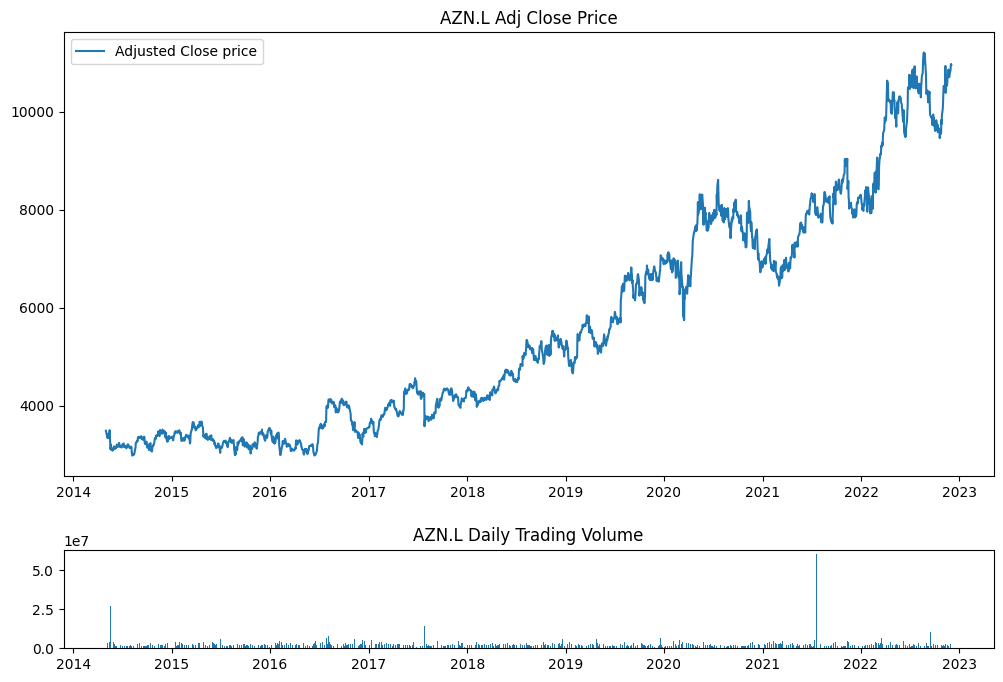

In [ ]:
# Plot Adjusted Close price and Volume

top = plt.subplot2grid((4,4), (0, 0), rowspan=3, colspan=4)
top.plot(azn_stock_df.index, azn_stock_df['Adj Close'], label = 'Adjusted Close price')
plt.title('AZN.L Adj Close Price')
plt.legend(loc=2)
bottom = plt.subplot2grid((4,4), (3,0), rowspan=1, colspan=4)
bottom.bar(azn_stock_df.index, azn_stock_df["Volume"])
plt.title('AZN.L Daily Trading Volume')
plt.gcf().set_size_inches(12,8)
plt.subplots_adjust(hspace=0.75)

## 6. Merge Stock and Sentiment Dataframes on Date

In [ ]:
# Merge data sets on date
merge = azn_stock_df.merge(azn_news_df_combined, how='inner', left_index=True, right_index=True)


In [ ]:
# Show merged data set
merge

Open         High          Low   Close    Adj Close   Volume  \
Date                                                                         
2016-05-09  3822.5  3991.316895  3817.752930  3944.5  3120.884033  2974767   
2016-05-12  3918.5  3981.150879  3874.500000  3880.0  3069.852051  2221661   
2016-05-17  3945.0  3962.500000  3915.639893  3930.5  3109.807617  2080482   
2016-05-18  3924.0  3996.110107  3883.000000  3900.5  3086.071289  2062546   
2016-05-25  3988.5  4044.899902  3974.850098  4014.5  3176.268311  2038005   
...            ...          ...          ...     ...          ...      ...   
2020-12-23  7307.0  7324.000000  7196.000000  7224.0  6725.597656  1588406   
2020-12-30  7570.0  7598.000000  7400.000000  7401.0  6890.385254  2290546   
2020-12-31  7400.0  7409.000000  7269.000000  7324.0  6818.697266  1135354   
2021-01-04  7425.0  7560.000000  7402.500000  7422.0  6909.937012  4373741   
2021-01-05  7445.0  7484.607910  7366.000000  7439.0  6925.763672  2800020   

           ticker publish_date  \
Date                             
2016-05-09  AZN.L  2016-05-09    
2016-05-12  AZN.L  2016-05-12    
2016-05-17  AZN.L  2016-05-17    
2016-05-18  AZN.L  2016-05-18    
2016-05-25  AZN.L  2016-05-25    
...           ...         ...    
2020-12-23  AZN.L  2020-12-23    
2020-12-30  AZN.L  2020-12-30    
2020-12-31  AZN.L  2020-12-31    
2021-01-04  AZN.L  2021-01-04    
2021-01-05  AZN.L  2021-01-05    

                                                                                                         title  \
Date                                                                                                             
2016-05-09  Sweden shares higher at close of trade; OMX Stockholm 30 up 1.45% By Investing.com                   
2016-05-12  AstraZeneca drug wins orphan status in thyroid cancer By Reuters                                     
2016-05-17  Novartis splits drugs business into two, pharma chief to leave By Reuters                            
2016-05-18  Pascal Soriot's big experiment: reinventing AstraZeneca By Reuters                                   
2016-05-25  French drugmaker Sanofi to step up push into China By Reuters                                        
...                                                                        ...                                   
2020-12-23  U.K. shares higher at close of trade; Investing.com United Kingdom 100 up 0.50% By Investing.com     
2020-12-30  Stocks making the biggest moves midday: AMC, Levi Strauss, Dynatrace, AstraZeneca & more             
2020-12-31  UK Stocks-Factors to watch on Dec 31 By Reuters                                                      
2021-01-04  UK Stocks-Factors to watch on Jan. 4 By Reuters                                                      
2021-01-05  The UK is delaying second vaccine shots and it's proving controversial. Here's what we know so far   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [ ]:
# Save merged DataFrame

merge.to_csv("azn_news_stock_merge.csv", sep=',', encoding='utf-8', header=True)

In [ ]:
# Show first row in combined news column

merge['news_combined'].iloc[0]

'Published May 09, 2016 17:05\n\n© Reuters. Sweden shares higher at close of trade; OMX Stockholm 30 up 1.45%\n\nBOL +0.50% Add to/Remove from a Portfolio ORRON 0.00% Add to/Remove from a Portfolio HMb -0.58% Add to/Remove from a Portfolio SSABa -1.34% Add to/Remove from a Portfolio AZN -0.70% Add to/Remove from a Portfolio GETIBs 0.00% Add to/Remove from a Portfolio OMXS30 -0.70% Add to/Remove from a Portfolio SX500... 0.41% Add to/Remove from a Portfolio SX20PI -1.02% Add to/Remove from a Portfolio SX30PI -0.91% Add to/Remove from a Portfolio\n\nInvesting.com – Sweden equities were higher at the close on Monday, as gains in the , and sectors propelled shares higher.\n\nAt the close in Stockholm, the gained 1.45%.\n\nThe biggest gainers of the session on the were Getinge AB ser. B (ST: ), which rose 4.58% or 7.6 points to trade at 173.5 at the close. AstraZeneca PLC (ST: ) added 3.80% or 17.2 points to end at 470.0 and Hennes & Mauritz AB, H & M ser. B (ST: ) was up 2.75% or 7.3 point

In [ ]:
# Iterate over rows in combined news column

for index, row in merge.iterrows():
    print (row["news_combined"])

Published May 09, 2016 17:05

© Reuters. Sweden shares higher at close of trade; OMX Stockholm 30 up 1.45%

BOL +0.50% Add to/Remove from a Portfolio ORRON 0.00% Add to/Remove from a Portfolio HMb -0.58% Add to/Remove from a Portfolio SSABa -1.34% Add to/Remove from a Portfolio AZN -0.70% Add to/Remove from a Portfolio GETIBs 0.00% Add to/Remove from a Portfolio OMXS30 -0.70% Add to/Remove from a Portfolio SX500... 0.41% Add to/Remove from a Portfolio SX20PI -1.02% Add to/Remove from a Portfolio SX30PI -0.91% Add to/Remove from a Portfolio

Investing.com – Sweden equities were higher at the close on Monday, as gains in the , and sectors propelled shares higher.

At the close in Stockholm, the gained 1.45%.

The biggest gainers of the session on the were Getinge AB ser. B (ST: ), which rose 4.58% or 7.6 points to trade at 173.5 at the close. AstraZeneca PLC (ST: ) added 3.80% or 17.2 points to end at 470.0 and Hennes & Mauritz AB, H & M ser. B (ST: ) was up 2.75% or 7.3 points to 272.7 

### Clean data in combined news column

Strip newline escape sequence (\n), unwanted punctuation and backslashes.  

In [ ]:
# Create empty list to append cleaned data from combined news column

clean_news = []

for i in range(0, len(merge["news_combined"])):
    clean_news.append(re.sub("\n", ' ', merge["news_combined"][i]))  # replace n\ with ' '
    clean_news[i] = re.sub(r'[^\w\d\s\']+', '', clean_news[i]) # remove unwanted punctuation and \'


In [ ]:
# Show first row in cleaned combined news column

clean_news[0]

'Published May 09 2016 1705   Reuters Sweden shares higher at close of trade OMX Stockholm 30 up 145  BOL 050 Add toRemove from a Portfolio ORRON 000 Add toRemove from a Portfolio HMb 058 Add toRemove from a Portfolio SSABa 134 Add toRemove from a Portfolio AZN 070 Add toRemove from a Portfolio GETIBs 000 Add toRemove from a Portfolio OMXS30 070 Add toRemove from a Portfolio SX500 041 Add toRemove from a Portfolio SX20PI 102 Add toRemove from a Portfolio SX30PI 091 Add toRemove from a Portfolio  Investingcom  Sweden equities were higher at the close on Monday as gains in the  and sectors propelled shares higher  At the close in Stockholm the gained 145  The biggest gainers of the session on the were Getinge AB ser B ST  which rose 458 or 76 points to trade at 1735 at the close AstraZeneca PLC ST  added 380 or 172 points to end at 4700 and Hennes  Mauritz AB H  M ser B ST  was up 275 or 73 points to 2727 in late trade  Biggest losers included SSAB AB ser A ST  which lost 698 or 220 poin

In [ ]:
# Add cleaned news column to merged data set

merge['news_cleaned'] = clean_news


merge['news_cleaned'][0]

'Published May 09 2016 1705   Reuters Sweden shares higher at close of trade OMX Stockholm 30 up 145  BOL 050 Add toRemove from a Portfolio ORRON 000 Add toRemove from a Portfolio HMb 058 Add toRemove from a Portfolio SSABa 134 Add toRemove from a Portfolio AZN 070 Add toRemove from a Portfolio GETIBs 000 Add toRemove from a Portfolio OMXS30 070 Add toRemove from a Portfolio SX500 041 Add toRemove from a Portfolio SX20PI 102 Add toRemove from a Portfolio SX30PI 091 Add toRemove from a Portfolio  Investingcom  Sweden equities were higher at the close on Monday as gains in the  and sectors propelled shares higher  At the close in Stockholm the gained 145  The biggest gainers of the session on the were Getinge AB ser B ST  which rose 458 or 76 points to trade at 1735 at the close AstraZeneca PLC ST  added 380 or 172 points to end at 4700 and Hennes  Mauritz AB H  M ser B ST  was up 275 or 73 points to 2727 in late trade  Biggest losers included SSAB AB ser A ST  which lost 698 or 220 poin

In [ ]:
# Show head of merged DataFrame

merge.head()

Open         High          Low   Close    Adj Close   Volume  \
Date                                                                         
2016-05-09  3822.5  3991.316895  3817.752930  3944.5  3120.884033  2974767   
2016-05-12  3918.5  3981.150879  3874.500000  3880.0  3069.852051  2221661   
2016-05-17  3945.0  3962.500000  3915.639893  3930.5  3109.807617  2080482   
2016-05-18  3924.0  3996.110107  3883.000000  3900.5  3086.071289  2062546   
2016-05-25  3988.5  4044.899902  3974.850098  4014.5  3176.268311  2038005   

           ticker publish_date  \
Date                             
2016-05-09  AZN.L  2016-05-09    
2016-05-12  AZN.L  2016-05-12    
2016-05-17  AZN.L  2016-05-17    
2016-05-18  AZN.L  2016-05-18    
2016-05-25  AZN.L  2016-05-25    

                                                                                         title  \
Date                                                                                             
2016-05-09  Sweden shares higher at close of trade; OMX Stockholm 30 up 1.45% By Investing.com   
2016-05-12  AstraZeneca drug wins orphan status in thyroid cancer By Reuters                     
2016-05-17  Novartis splits drugs business into two, pharma chief to leave By Reuters            
2016-05-18  Pascal Soriot's big experiment: reinventing AstraZeneca By Reuters                   
2016-05-25  French drugmaker Sanofi to step up push into China By Reuters                        

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             

In [ ]:
# Save merged DataFrame

merge.to_csv("azn__merge_cleaned.csv", sep=',', encoding='utf-8', header=True)

## 7. Sentiment Analysis

TextBlob will be used to get subjectivity and polarity scores for the cleaned and merged news data. Polarity is a float which lies in the range of [-1,1] where 1 means positive statement and -1 means a negative statement. Subjective sentences generally refer to personal opinion, emotion or judgement whereas objective refers to factual information. Subjectivity is also a float which lies in the range of [0,1] where 0 is objective and 1 is subjective.

In [ ]:
# Create function to get subjectivity
def getSubjectivity(text):
  return TextBlob(text).sentiment.subjectivity

# Create function to get polarity
def getPolarity(text):
  return TextBlob(text).sentiment.polarity

In [ ]:
# Create new columns
merge['subjectivity'] = merge['news_cleaned'].apply(getSubjectivity)
merge['polarity'] = merge['news_cleaned'].apply(getPolarity)

In [ ]:
# Show new columns
merge.head(3)

Open         High          Low   Close    Adj Close   Volume  \
Date                                                                         
2016-05-09  3822.5  3991.316895  3817.752930  3944.5  3120.884033  2974767   
2016-05-12  3918.5  3981.150879  3874.500000  3880.0  3069.852051  2221661   
2016-05-17  3945.0  3962.500000  3915.639893  3930.5  3109.807617  2080482   

           ticker publish_date  \
Date                             
2016-05-09  AZN.L  2016-05-09    
2016-05-12  AZN.L  2016-05-12    
2016-05-17  AZN.L  2016-05-17    

                                                                                         title  \
Date                                                                                             
2016-05-09  Sweden shares higher at close of trade; OMX Stockholm 30 up 1.45% By Investing.com   
2016-05-12  AstraZeneca drug wins orphan status in thyroid cancer By Reuters                     
2016-05-17  Novartis splits drugs business into two, pharma chief to leave By Reuters            

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 

In [ ]:
# Show shape of DataFrame
merge.shape

(420, 19)

In [ ]:
# Save DataFrame with subjectivity and polarity scores
merge.to_csv("azn__merge_cleaned_subj_pol.csv", sep=',', encoding='utf-8', header=True)

## 9. Feature engineering

We will calculate whether the next day Adjusted Close price increased/held or decreased and label these as 1 and 0 respectively to build and train machine learning classifier models to predict price direction based on sentiment.

In [ ]:
# Create copy of stock data

azn_stock_df_label = azn_stock_df.copy()
azn_stock_df_label

Open          High           Low    Close     Adj Close  \
Date                                                                     
2014-05-02  4825.0   4946.413086   4716.500000   4808.0   3491.310547    
2014-05-06  4735.0   4762.500000   4657.500000   4677.5   3396.549561    
2014-05-07  4622.0   4664.000000   4608.527832   4631.0   3362.782959    
2014-05-08  4630.0   4735.000000   4630.000000   4713.0   3422.327637    
2014-05-09  4665.0   4678.000000   4598.500000   4600.5   3340.635986    
...            ...           ...           ...      ...           ...    
2022-11-28  11000.0  11098.000000  10876.000000  11050.0  10823.622070   
2022-11-29  11034.0  11176.000000  10988.000000  11060.0  10833.416992   
2022-11-30  11108.0  11228.000000  11056.000000  11166.0  10937.246094   
2022-12-01  11200.0  11222.000000  11102.000000  11200.0  10970.549805   
2022-12-02  11168.0  11230.000000  11074.000000  11178.0  10949.000977   

             Volume  
Date                 
2014-05-02  8406892  
2014-05-06  3705878  
2014-05-07  3988894  
2014-05-08  3380811  
2014-05-09  4069204  
...             ...  
2022-11-28  1157755  
2022-11-29  2434217  
2022-11-30  3794486  
2022-12-01  1282615  
2022-12-02  1347226  

[2172 rows x 6 columns]

In [ ]:
# "1" when AZN Adj Close value rose or stayed as the same;
# "0" when AZN Adj Close value decreased.

azn_stock_df_label['Adj Close Next'] = azn_stock_df_label['Adj Close'].shift(-1)
azn_stock_df_label['Label'] = azn_stock_df_label.apply(lambda x: 1 if (x['Adj Close Next']>= x['Adj Close']) else 0, axis =1)

azn_stock_df_label[['Adj Close', 'Adj Close Next', 'Label']].head(5)

Adj Close  Adj Close Next  Label
Date                                          
2014-05-02  3491.310547  3396.549561     0    
2014-05-06  3396.549561  3362.782959     0    
2014-05-07  3362.782959  3422.327637     1    
2014-05-08  3422.327637  3340.635986     0    
2014-05-09  3340.635986  3347.533691     1

In [ ]:
# Save DataFrame

azn_stock_df_label.to_pickle("azn_stock_df_labels.pkl")

In [ ]:
azn_stock_df_label.to_csv("azn_stock_df_label.csv", sep=',', encoding='utf-8', header=True)

In [ ]:
# Show Adj Close Next and Label with Date

azn_stock_df_label_adj_nxt = azn_stock_df_label[['Adj Close Next', 'Label']]
azn_stock_df_label_adj_nxt

Adj Close Next  Label
Date                             
2014-05-02  3396.549561     0    
2014-05-06  3362.782959     0    
2014-05-07  3422.327637     1    
2014-05-08  3340.635986     0    
2014-05-09  3347.533691     1    
...                 ...    ..    
2022-11-28  10833.416992    1    
2022-11-29  10937.246094    1    
2022-11-30  10970.549805    1    
2022-12-01  10949.000977    0    
2022-12-02 NaN              0    

[2172 rows x 2 columns]

In [ ]:
# Drop NaN row

azn_stock_df_label_adj_nxt = azn_stock_df_label_adj_nxt.dropna()
azn_stock_df_label_adj_nxt

Adj Close Next  Label
Date                             
2014-05-02  3396.549561     0    
2014-05-06  3362.782959     0    
2014-05-07  3422.327637     1    
2014-05-08  3340.635986     0    
2014-05-09  3347.533691     1    
...                 ...    ..    
2022-11-25  10823.622070    1    
2022-11-28  10833.416992    1    
2022-11-29  10937.246094    1    
2022-11-30  10970.549805    1    
2022-12-01  10949.000977    0    

[2171 rows x 2 columns]

In [ ]:
# Merge DataFrames on date
merge2 = azn_stock_df.merge(azn_stock_df_label_adj_nxt, how='inner', left_index=True, right_index=True)

In [ ]:
# Drop NaN row and show merged DataFrame
merge2 = merge2.dropna()
merge2

Open          High           Low    Close     Adj Close  \
Date                                                                     
2014-05-02  4825.0   4946.413086   4716.500000   4808.0   3491.310547    
2014-05-06  4735.0   4762.500000   4657.500000   4677.5   3396.549561    
2014-05-07  4622.0   4664.000000   4608.527832   4631.0   3362.782959    
2014-05-08  4630.0   4735.000000   4630.000000   4713.0   3422.327637    
2014-05-09  4665.0   4678.000000   4598.500000   4600.5   3340.635986    
...            ...           ...           ...      ...           ...    
2022-11-25  10934.0  11012.000000  10890.000000  10954.0  10729.589844   
2022-11-28  11000.0  11098.000000  10876.000000  11050.0  10823.622070   
2022-11-29  11034.0  11176.000000  10988.000000  11060.0  10833.416992   
2022-11-30  11108.0  11228.000000  11056.000000  11166.0  10937.246094   
2022-12-01  11200.0  11222.000000  11102.000000  11200.0  10970.549805   

             Volume  Adj Close Next  Label  
Date                                        
2014-05-02  8406892  3396.549561     0      
2014-05-06  3705878  3362.782959     0      
2014-05-07  3988894  3422.327637     1      
2014-05-08  3380811  3340.635986     0      
2014-05-09  4069204  3347.533691     1      
...             ...          ...    ..      
2022-11-25  839863   10823.622070    1      
2022-11-28  1157755  10833.416992    1      
2022-11-29  2434217  10937.246094    1      
2022-11-30  3794486  10970.549805    1      
2022-12-01  1282615  10949.000977    0      

[2171 rows x 8 columns]

In [ ]:
# Save DataFrame
merge2.to_csv("azn_prices_labels.csv", sep=',', encoding='utf-8', header=True)

In [ ]:
merge2.to_pickle("azn_prices_labels.pkl")

In [ ]:
# Merge next day Adjusted Close price and Label with combined stock data and sentiment DataFrame

merge3 = azn_stock_df_label_adj_nxt.merge(merge, how='inner', left_index=True, right_index=True)
merge3

Adj Close Next  Label    Open         High          Low   Close  \
Date                                                                          
2016-05-09  3107.829346     0      3822.5  3991.316895  3817.752930  3944.5   
2016-05-12  3117.323242     1      3918.5  3981.150879  3874.500000  3880.0   
2016-05-17  3086.071289     0      3945.0  3962.500000  3915.639893  3930.5   
2016-05-18  3016.050537     0      3924.0  3996.110107  3883.000000  3900.5   
2016-05-25  3173.894531     0      3988.5  4044.899902  3974.850098  4014.5   
...                 ...    ..         ...          ...          ...     ...   
2020-12-23  6724.666016     0      7307.0  7324.000000  7196.000000  7224.0   
2020-12-30  6818.697266     0      7570.0  7598.000000  7400.000000  7401.0   
2020-12-31  6909.937012     1      7400.0  7409.000000  7269.000000  7324.0   
2021-01-04  6925.763672     1      7425.0  7560.000000  7402.500000  7422.0   
2021-01-05  6993.727539     1      7445.0  7484.607910  7366.000000  7439.0   

              Adj Close   Volume ticker publish_date  ...  \
Date                                                  ...   
2016-05-09  3120.884033  2974767  AZN.L  2016-05-09   ...   
2016-05-12  3069.852051  2221661  AZN.L  2016-05-12   ...   
2016-05-17  3109.807617  2080482  AZN.L  2016-05-17   ...   
2016-05-18  3086.071289  2062546  AZN.L  2016-05-18   ...   
2016-05-25  3176.268311  2038005  AZN.L  2016-05-25   ...   
...                 ...      ...    ...         ...   ...   
2020-12-23  6725.597656  1588406  AZN.L  2020-12-23   ...   
2020-12-30  6890.385254  2290546  AZN.L  2020-12-30   ...   
2020-12-31  6818.697266  1135354  AZN.L  2020-12-31   ...   
2021-01-04  6909.937012  4373741  AZN.L  2021-01-04   ...   
2021-01-05  6925.763672  2800020  AZN.L  2021-01-05   ...   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              

In [ ]:
# Save merged DataFrame

merge3.to_csv("azn_prices_labels_news.csv", sep=',', encoding='utf-8', header=True)

In [ ]:
merge3.to_pickle("azn_prices_labels_news.pkl")

In [ ]:
merge3 = pd.read_pickle("azn_prices_labels_news.pkl")

In [ ]:
# Collapse data set to keep relevant stock price and sentiment score columns only

keep_columns = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'subjectivity', 'polarity', 'compound', 'neg',	'neu',	'pos', 'Label']
df =  merge3[keep_columns]
df

Open         High          Low   Close    Adj Close   Volume  \
Date                                                                         
2016-05-09  3822.5  3991.316895  3817.752930  3944.5  3120.884033  2974767   
2016-05-12  3918.5  3981.150879  3874.500000  3880.0  3069.852051  2221661   
2016-05-17  3945.0  3962.500000  3915.639893  3930.5  3109.807617  2080482   
2016-05-18  3924.0  3996.110107  3883.000000  3900.5  3086.071289  2062546   
2016-05-25  3988.5  4044.899902  3974.850098  4014.5  3176.268311  2038005   
...            ...          ...          ...     ...          ...      ...   
2020-12-23  7307.0  7324.000000  7196.000000  7224.0  6725.597656  1588406   
2020-12-30  7570.0  7598.000000  7400.000000  7401.0  6890.385254  2290546   
2020-12-31  7400.0  7409.000000  7269.000000  7324.0  6818.697266  1135354   
2021-01-04  7425.0  7560.000000  7402.500000  7422.0  6909.937012  4373741   
2021-01-05  7445.0  7484.607910  7366.000000  7439.0  6925.763672  2800020   

            subjectivity  polarity  compound    neg    neu    pos  Label  
Date                                                                      
2016-05-09  0.608889      0.029444 -0.3818    0.036  0.933  0.031  0      
2016-05-12  0.447153      0.074172 -0.9485    0.168  0.694  0.138  1      
2016-05-17  0.414360      0.060816 -0.7582    0.064  0.863  0.073  0      
2016-05-18  0.397084      0.115780  0.9962    0.060  0.825  0.115  0      
2016-05-25  0.321557      0.042688  0.8946    0.051  0.878  0.071  0      
...              ...           ...     ...      ...    ...    ... ..      
2020-12-23  0.614530      0.114957 -0.3400    0.036  0.933  0.031  0      
2020-12-30  0.420452      0.110058  0.9890    0.024  0.844  0.133  0      
2020-12-31  0.363492      0.116934  0.9625    0.050  0.843  0.106  1      
2021-01-04  0.374229      0.113934 -0.8922    0.071  0.875  0.054  1      
2021-01-05  0.359634      0.134842  0.7932    0.045  0.902  0.052  1      

[420 rows x 13 columns]

## 10. Modelling

Split the data in feature matrix (X) and target vector (y).


In [ ]:
# Create feature data set
X = df
X = np.array(X.drop(['Label'], 1))

# Create target data set
y = np.array(df['Label'])

We will split the data into train and test sets to verify predictions. Time series data cannot be split randomly as this would introduce look-ahead bias so the first 80% will be the training set and the last 20% the test set.

In [ ]:
# Split data into 80% training and 20% testing data sets

split = int(0.8*len(df))

In [ ]:
X_train = X[0:split]
y_train = y[0:split]

X_test = X[split:]
y_test = y[split:]

In [ ]:
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(336, 12)
(336,)
(84, 12)
(84,)


In [ ]:
# Create and train the model
model = LinearDiscriminantAnalysis().fit(X_train, y_train)

In [ ]:
# Show model's predictions
predictions = model.predict(X_test)
predictions

array([0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

In [ ]:
# Show actual values
y_test

array([0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0,
       1, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1,
       1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 1])

In [ ]:
# Show model metrics
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.63      0.37      0.47        46
           1       0.49      0.74      0.59        38

    accuracy                           0.54        84
   macro avg       0.56      0.55      0.53        84
weighted avg       0.57      0.54      0.52        84



### Feature scaling

We will standardise the data using scikit-learn's preprocessing.scale() algorithm so that it is all on one scale.

In [ ]:
# Standardise X's
X_train = scale(X_train)
X_test = scale(X_test)

### Create function for confusion matrix to visualise performance

In [ ]:
# Function for confusion matrix

def plot_confusion_matrix(y_true, y_pred, labels=["Decrease", "Increase"],
                          normalize=False, title=None, cmap=plt.cm.coolwarm):

    cm = confusion_matrix(y_true, y_pred)
    fig, ax = plt.subplots(figsize=(12,6))
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=labels, yticklabels=labels,
           title=title,
           ylabel='ACTUAL',
           xlabel='PREDICTED')
    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")
    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.5
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="snow" if cm[i, j] > thresh else "orange",
                    size=26)
    ax.grid(False)
    fig.tight_layout()
    return ax

### Create dictionary of classifiers to train and predict on


-------------- LinearDiscriminantAnalysis ---------------



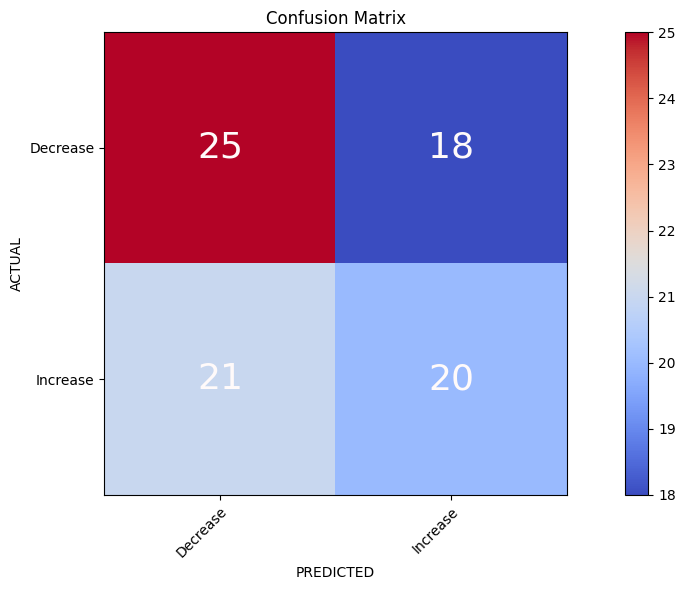

              precision    recall  f1-score   support

    Decrease       0.54      0.58      0.56        43
    Increase       0.53      0.49      0.51        41

    accuracy                           0.54        84
   macro avg       0.53      0.53      0.53        84
weighted avg       0.54      0.54      0.53        84


-------------- SVM Classification ---------------



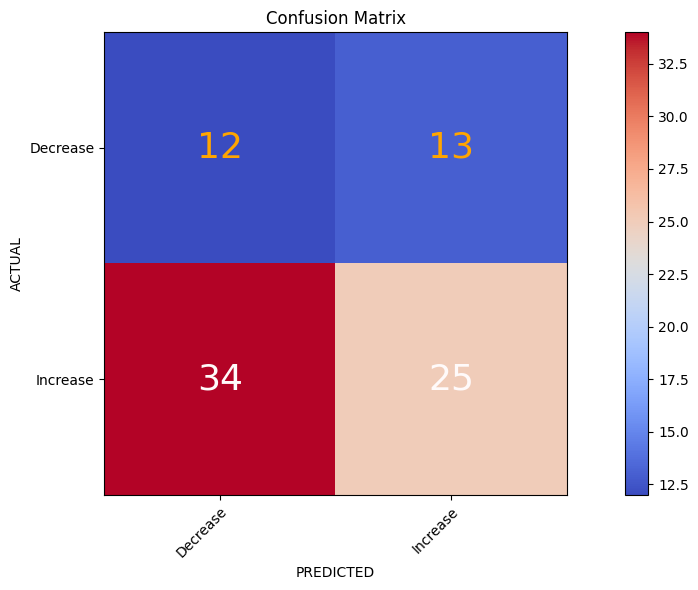

              precision    recall  f1-score   support

    Decrease       0.26      0.48      0.34        25
    Increase       0.66      0.42      0.52        59

    accuracy                           0.44        84
   macro avg       0.46      0.45      0.43        84
weighted avg       0.54      0.44      0.46        84


-------------- SGDClassifier ---------------



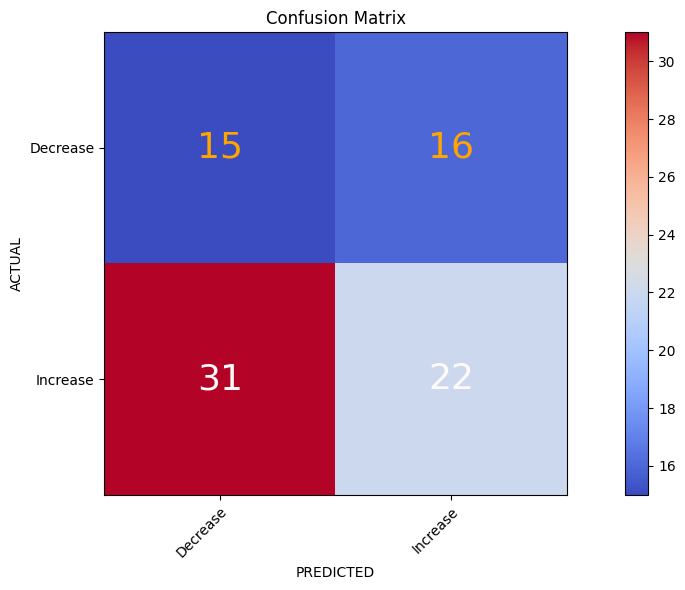

              precision    recall  f1-score   support

    Decrease       0.33      0.48      0.39        31
    Increase       0.58      0.42      0.48        53

    accuracy                           0.44        84
   macro avg       0.45      0.45      0.44        84
weighted avg       0.49      0.44      0.45        84


-------------- KNeighborsClassifier ---------------



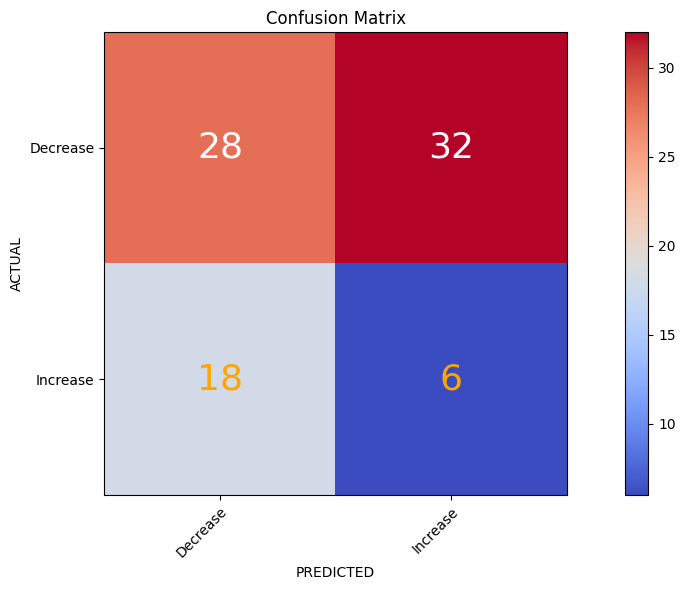

              precision    recall  f1-score   support

    Decrease       0.61      0.47      0.53        60
    Increase       0.16      0.25      0.19        24

    accuracy                           0.40        84
   macro avg       0.38      0.36      0.36        84
weighted avg       0.48      0.40      0.43        84


-------------- GaussianProcessClassifier ---------------



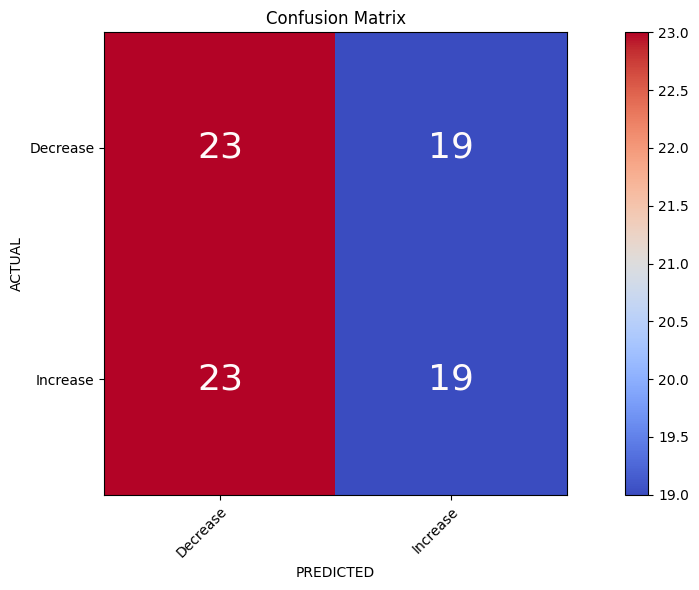

              precision    recall  f1-score   support

    Decrease       0.50      0.55      0.52        42
    Increase       0.50      0.45      0.48        42

    accuracy                           0.50        84
   macro avg       0.50      0.50      0.50        84
weighted avg       0.50      0.50      0.50        84


-------------- RandomForestClassifier ---------------



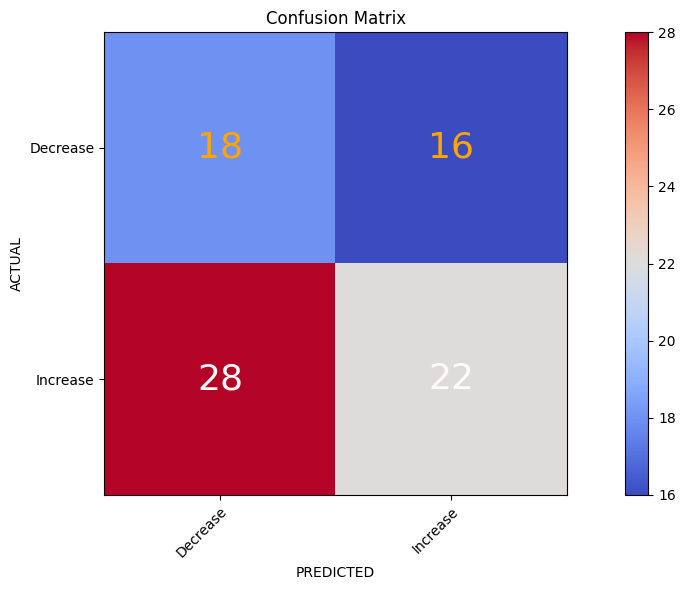

              precision    recall  f1-score   support

    Decrease       0.39      0.53      0.45        34
    Increase       0.58      0.44      0.50        50

    accuracy                           0.48        84
   macro avg       0.49      0.48      0.47        84
weighted avg       0.50      0.48      0.48        84



In [ ]:
# test models
models = {  'LinearDiscriminantAnalysis':LinearDiscriminantAnalysis(),
            'SVM Classification': SVC(),
            'SGDClassifier': SGDClassifier(loss="hinge", penalty="l2", max_iter=100),
            'KNeighborsClassifier':KNeighborsClassifier(n_neighbors=10),
            'GaussianProcessClassifier': GaussianProcessClassifier(),
            'RandomForestClassifier': RandomForestClassifier(n_estimators=100)
            }

for model_name in models.keys():

    model = models[model_name]
    print('\n'+'--------------',model_name,'---------------'+'\n')
    model.fit(X_train,y_train)
    # Plot confusion matrix
    plot_confusion_matrix(model.predict(X_test),y_test, title="Confusion Matrix")
    np.set_printoptions(precision=1)
    plt.show()
    # Final Classification Report
    print(classification_report(model.predict(X_test),y_test, target_names=['Decrease', 'Increase']))